In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
from numpy.linalg import norm
%matplotlib inline

# Case 1 Error Convergence Exercise
Case 1 involves $\textbf{B} = B_0 \hat{z}$ and $\textbf{E} = 0$. This notebook will look at three different integrators and then create a plot of error convergence (which is error vs timestep size)

## Analytical Solution
Solving the same Lorentz force equation of motion **non-relativistically** yields the modified form
$$
\frac{\text{d}\textbf{p}}{\text{d}t} = q (\textbf{v} \times \textbf{B}) \Longrightarrow m \dot{\textbf{v}} = q (\textbf{v} \times \textbf{B}) \Longrightarrow \dot{\textbf{v}} = \frac{q}{m} (\textbf{v} \times \textbf{B}),
$$
As this is only for case 1, I won't solve it generally. Moving on-
$$
\dot{\textbf{v}} = \frac{q}{m} (\textbf{v} \times \textbf{B}) = \frac{q}{m} \begin{vmatrix}
\hat{x} & \hat{y} & \hat{z} \\
v_x & v_y & v_z \\
0 & 0 & B_z
\end{vmatrix}
= \frac{q}{m} \left(v_y B_z \hat{x} - v_x B_z\hat{y}\right)
$$
We can get two equations of motion for $\textbf{v}_x$ and $\textbf{v}_y$

$$
\dot{\textbf{v}}_x = \frac{qB_z}{m}v_y \hat{x} = \omega v_y \hat{x}
$$
$$
\dot{\textbf{v}}_y = -\frac{qB_z}{m}v_x \hat{y} = -\omega v_x \hat{y}
$$
where $\omega$ is the cyclotron frequency $qB/m$. Taking the derivative of one and plugging it into the other shows that these equations are SHM:
$$
\boxed{\ddot{\textbf{v}}_y = -\omega^2 v_y \hat{y}} \qquad \boxed{\ddot{\textbf{v}}_x = -\omega^2 v_x \hat{x}}
$$
So, solutions involving a linear combination of sines and cosines can be applied to this case:
$$
v_y = A\sin(\omega t) + B\cos(\omega t) \qquad v_x = C\sin(\omega t) + D\cos(\omega t)
$$
### Particular Solutions
To get the particular solution that I need, let the particle be moving in the $\hat{x}$ direction. At $t=0$, $B$ and $C$ need to drop out of the solutions to be physical. Also, $A$ and $D$ need to be the initial velocities, leaving:

$$
\boxed{v_y = -v_0\sin(\omega t)} \qquad \boxed{v_x = v_0\cos(\omega t)}
$$


## Other Included Things
- Error Convergence
- Time-Dependant Fields


# TODO
- Adams-Bashforth 4 Technique, as a check for the slopes. This should be around four?

In [2]:
### Constants
q  = 1     # charge of particle (Coulombs)
m  = 1     # mass of particle   (kg)

### Initial Conditions
B_0 = [0,0,5]       # Strength of B Field [B0_x, B0_y, B0_z]
r_0 = [0,0,0]       # Particle Position   [r0_x, r0_y, r0_z]
v_0 = [1,0,0]       # Particle Velocity   [v0_x, v0_y, v0_z]

### Lambda for Analytical Solutions
v_analytical_lam = lambda t: np.array([
    norm(v_0) * np.cos(q * norm(B_0) * t / m),
   -norm(v_0) * np.sin(q * norm(B_0) * t / m)
])

### Functional Forms of Fields
const_bfld = lambda t: B_0

### Analytical Solution

In [ ]:
def get_analytical_v(dt, sim_len):

    ### Simulation Parameters
    N = int(sim_len / dt)     # number of points

    ### Initialize Tracked Variables
    v = np.zeros((N+1,3))    # Particle Velocity

    for i in range(N+1):
        # Update the velocity according to the Lorentz force equation
        v[i] = np.array([
            norm(v_0) * np.cos(q * norm(B_0) * (i*dt) / m), #x
           -norm(v_0) * np.sin(q * norm(B_0) * (i*dt) / m), #y
            0                                               #z (just for proper sizing)
        ])

    return v

### Explicit (Forward) Euler

In [4]:
### Perform the Explicit Euler Algorithm
def explicit_euler(dt, sim_len, bfld):

    ### Simulation Parameters
    N = int(sim_len / dt)     # number of points
    t = np.linspace(0, sim_len, N+1).reshape((N+1,1))

    ### Initialize Tracked Variables
    B = np.zeros((N+1,3))    # Magnetic Field
    r = np.zeros((N+1,3))    # Particle Position
    v = np.zeros((N+1,3))    # Particle Velocity

    ### Set Initial Conditions
    B[0] = B_0
    r[0] = r_0
    v[0] = v_0

    for i in range(N):
        # Update B Field for current timestep
        B[i] = bfld(i * dt)

        # Update the velocity according to the Lorentz force equation
        v[i+1] = v[i] + q * np.linalg.cross(v[i], B[i]) / m * dt

        # Update the position according to the velocity
        r[i+1] = r[i] + v[i+1] * dt

    return r, v, t

### Implicit (Backward) Euler

In [5]:
### Perform the Implicit (Backward) Euler Algorithm
def implicit_euler(dt, sim_len, bfld):

    ### Simulation Parameters
    N = int(sim_len / dt)     # number of points
    t = np.linspace(0, sim_len, N+1).reshape((N+1,1))

    ### Initialize Tracked Variables
    B = np.zeros((N+1,3))    # Magnetic Field
    r = np.zeros((N+1,3))    # Particle Position
    v = np.zeros((N+1,3))    # Particle Velocity

    ### Set Initial Conditions
    B[0] = B_0
    r[0] = r_0
    v[0] = v_0

    for i in range(N):
        # Update B Field for current timestep
        B[i] = bfld(i * dt)

        ### Build matrix to be solved for equation
        A = np.array([
            [  0.0   ,  B[i][2], -B[i][1]],
            [-B[i][2],    0.0  ,  B[i][0]],
            [ B[i][1], -B[i][0],    0.0]
        ])

        # scale it properly
        A = (q / m) * A
        M = np.linalg.inv(np.identity(3) - A * dt)

        # this handles the x-y motion, which is affected by the b field for this case
        v[i+1] = np.linalg.matmul(M,v[i])

        # Update the position according to the velocity
        r[i+1] = r[i] + v[i+1] * dt

    return r, v, t

### Runge-Kutta (RK4)

In [6]:
def rk4(dt, sim_len, bfld):
    ### Simulation Parameters
    N = int(sim_len / dt)     # number of points
    t = np.linspace(0, sim_len, N+1).reshape((N+1,1))

    ### Initialize Tracked Variables
    B = np.zeros((N+1,3))    # Magnetic Field
    r = np.zeros((N+1,3))    # Particle Position
    v = np.zeros((N+1,3))    # Particle Velocity

    ### Set Initial Conditions
    B[0] = B_0
    r[0] = r_0
    v[0] = v_0

    for i in range(N):
        # Update B Field for current timestep
        B[i] = bfld(i * dt)

        ### Build matrix for equation
        A = np.array([
            [  0.0   ,  B[i][2], -B[i][1]],
            [-B[i][2],    0.0  ,  B[i][0]],
            [ B[i][1], -B[i][0],    0.0]
        ])

        # scale it properly
        A = (q/m) * A

        ## compute the four k values
        k_1 = np.matmul(A, v[i])
        # this adds the timestep to both indices of the vector
        # wanted to clarify as vector + scalar is not well defined
        k_2 = np.matmul(A, v[i] + k_1 * dt/2)
        k_3 = np.matmul(A, v[i] + k_2 * dt/2)
        k_4 = np.matmul(A, v[i] + k_3 * dt)

        ## get the next value
        v[i+1] = v[i] + (k_1 + 2*k_2 + 2*k_3 + k_4) * dt/6

        # Update the position according to the velocity
        r[i+1] = r[i] + v[i+1] * dt

    return r, v, t

### Adams-Bashforth Four-Step Explicit Method (Adams4)
This guy needs the first FOUR values from another method, then he can start going on his own adventure. I'll use the RK4 method as is one of the better ones I've done. He is defined by
$$
w_0 = \alpha_0,\quad w_1 = \alpha_1, \quad w_2 = \alpha_2, \quad w_3 = \alpha_3
$$
$$
w_{i+1} = w_i + \frac{h}{24}\left[55 f(t_i, w_i) - 59 f(t_{i-1}, w_{i-1}) + 37 f(t_{i-2}, w_{i-2}) - 9 f(t_{i-3}, w_{i-3}))\right]
$$


In [7]:
def adams4(dt, sim_len, bfld):
    ### Simulation Parameters
    N = int(sim_len / dt)
    t = np.linspace(0, sim_len, N+1).reshape((N+1,1))

    ### Initialize Tracked Variables
    B = np.zeros((N+1,3))    # Magnetic Field
    r = np.zeros((N+1,3))    # Particle Position
    v = np.zeros((N+1,3))    # Particle Velocity

    ### Set Initial Conditions
    B[0] = B_0
    r[0] = r_0

    # Inform the method from the first four values from the analytical solution
    v[0:4] = get_analytical_v(dt,sim_len)[0:4]

    ### Loop over the other values
    for i in range(3,N):

        # Update B Field for current timestep
        B[i] = bfld(i * dt)

        ### Build matrix for equation
        A = np.array([
            [  0.0   ,  B[i][2], -B[i][1]],
            [-B[i][2],    0.0  ,  B[i][0]],
            [ B[i][1], -B[i][0],    0.0]
        ])

        # scale it properly
        A = (q/m) * A

        # make some constants that correspond with terms for readability
        c1 = 55 * np.matmul(A, v[i])
        c2 = 59 * np.matmul(A, v[i-1])
        c3 = 37 * np.matmul(A, v[i-2])
        c4 = 9  * np.matmul(A, v[i-3])

        v[i+1] = v[i] + dt * (c1 - c2 + c3 - c4)/24

        # Update the position according to the velocity
        r[i+1] = r[i] + v[i+1] * dt


    return r, v, t


# Error Convergence Exercise
Take the various integrators and get their errors compared with the analytical solution for the case where the particle:
- is initially moving in the $\hat{x}$ direction
- inside of a $\textbf{B}$ field in the $\hat{z}$ direction

## Various Notes
- Good rule of thumb -> 15 points per cycle of a wave, so this is how I can determine $dt$.

In [8]:
# go over just one cycle
sim_length = (2*np.pi*m)/(q*norm(B_0))
dt_vals = np.arange(0.1, 0.001, -0.0025)
print(dt_vals)

Err_vals_fwdEuler = np.array([], dtype=np.int64).reshape(0,1)
Err_vals_bwdEuler = np.array([], dtype=np.int64).reshape(0,1)
Err_vals_rk4      = np.array([], dtype=np.int64).reshape(0,1)
Err_vals_adams4   = np.array([], dtype=np.int64).reshape(0,1)

def relativeError(numerical, analytical):
    return norm(numerical[:,1] - analytical[:,1]) / norm(analytical[:,1])

# apply each integrator for different values of h
for dt in dt_vals:
    ### Analytical Solution
    v_analytical = get_analytical_v(dt, sim_length)

    ### Forward Euler
    _, v_fwdEuler, t = explicit_euler(dt, sim_length, const_bfld)
    Err_vals_fwdEuler = np.vstack((Err_vals_fwdEuler, relativeError(v_fwdEuler, v_analytical)))

    ### Backward Euler
    _, v_bwdEuler, _ = implicit_euler(dt, sim_length, const_bfld)
    Err_vals_bwdEuler = np.vstack((Err_vals_bwdEuler, relativeError(v_bwdEuler, v_analytical)))

    ### RK4
    _, v_rk4, _ = rk4(dt, sim_length, const_bfld)
    Err_vals_rk4 = np.vstack((Err_vals_rk4, relativeError(v_rk4, v_analytical)))

    ### Adams4
    _, v_adams4, _ = adams4(dt, sim_length, const_bfld)
    Err_vals_adams4 = np.vstack((Err_vals_adams4, relativeError(v_adams4, v_analytical)))


[0.1    0.0975 0.095  0.0925 0.09   0.0875 0.085  0.0825 0.08   0.0775
 0.075  0.0725 0.07   0.0675 0.065  0.0625 0.06   0.0575 0.055  0.0525
 0.05   0.0475 0.045  0.0425 0.04   0.0375 0.035  0.0325 0.03   0.0275
 0.025  0.0225 0.02   0.0175 0.015  0.0125 0.01   0.0075 0.005  0.0025]


In [9]:
print(relativeError(v_bwdEuler, v_analytical)) # ok they do the same thing


0.02188129441644109


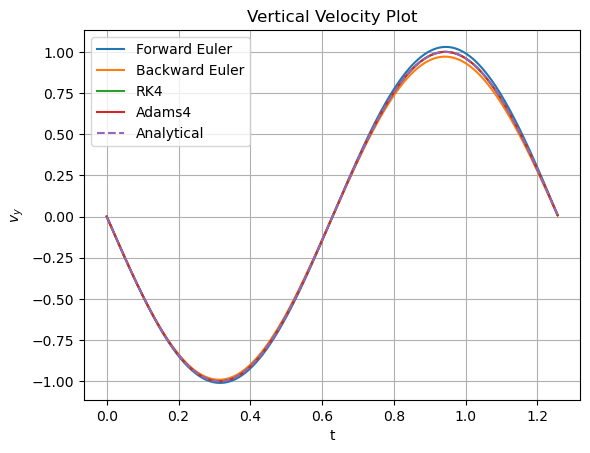

In [16]:
### Make plots of the various v against t
# note this is for the lowest time step
plt.plot(t, v_fwdEuler[:,1], '-', label = 'Forward Euler')
plt.plot(t, v_bwdEuler[:,1], '-', label = 'Backward Euler')
plt.plot(t, v_rk4[:,1], '-', label = 'RK4')
plt.plot(t, v_adams4[:,1], '-', label = 'Adams4')
plt.plot(t, v_analytical[:,1], '--', label = 'Analytical')
plt.grid()
plt.xlabel('t')
plt.ylabel('$v_y$')
plt.legend()
plt.title('Vertical Velocity Plot')
plt.show()

It's a bit difficult to see, but the velocities in this case are doing what I expect them to.
- The Explicit Euler is gaining energy out of nowhere
- The Backward Euler is losing energy
- The RK4 is matching with the analytical solution very well

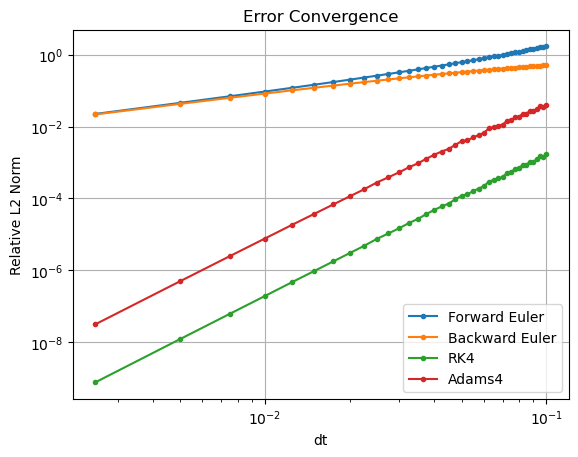

In [11]:
# visualize convergence plot
plt.loglog(dt_vals, Err_vals_fwdEuler, '.-', label = 'Forward Euler')
plt.loglog(dt_vals, Err_vals_bwdEuler, '.-', label = 'Backward Euler')
plt.loglog(dt_vals, Err_vals_rk4, '.-', label = 'RK4')
plt.loglog(dt_vals, Err_vals_adams4, '.-', label = 'Adams4')
plt.grid()
plt.xlabel('dt')
plt.ylabel('Relative L2 Norm')
plt.legend()
plt.title('Error Convergence')
plt.show()

In [17]:
# Fit each line
log_dt = np.log(dt_vals)
A = np.vstack([log_dt, np.ones(len(log_dt))]).T

m_fwdEuler, b_fwdEuler = np.linalg.lstsq(A, np.log(Err_vals_fwdEuler))[0]
m_bwdEuler, b_bwdEuler = np.linalg.lstsq(A, np.log(Err_vals_bwdEuler))[0]
m_rk4, b_rk4 = np.linalg.lstsq(A, np.log(Err_vals_rk4))[0]
m_adams4, b_adams4 = np.linalg.lstsq(A, np.log(Err_vals_adams4))[0]

# return results
print(f"Forward Euler:  m={m_fwdEuler[0]:.3f}, b={b_fwdEuler[0]:.3f}")
print(f"Backward Euler: m={m_bwdEuler[0]:.3f}, b={b_bwdEuler[0]:.3f}")
print(f"RK4:            m={m_rk4[0]:.3f}, b={b_rk4[0]:.3f}")
print(f"Adams4:         m={m_adams4[0]:.3f}, b={b_adams4[0]:.3f}")

Forward Euler:  m=1.207, b=3.200
Backward Euler: m=0.831, b=1.344
RK4:            m=3.961, b=2.766
Adams4:         m=3.791, b=5.679


## Time Dependent Field Exercise
Here is my first attempt at a charged particle moving under the influence of an oscillating magnetic field.

In [13]:
# sin_bfld = lambda t: B_0 * np.array([0, 0, 8*np.sin(t)])

# # Forward Euler
# r_fwdEuler, v_fwdEuler, t = explicit_euler(0.01, sim_length, sin_bfld)

# # Backward Euler
# r_bwdEuler, v_bwdEuler, t = implicit_euler(0.01, sim_length, sin_bfld)

# # Rk4
# r_rk4, v_rk4, t = rk4(0.01, sim_length, sin_bfld)

In [14]:
# # Plot particle position, using the RK4 as it seems the most stable for this exercise
# plt.plot(r_rk4[:, 0], r_rk4[:, 1], '-', label = 'RK4')
# plt.grid()
# plt.xlabel('$r_x$')
# plt.ylabel('$r_y$')
# plt.legend()
# plt.title('Particle Position')
# plt.gca().set_aspect("equal")
# plt.show()